Taxi Fare Prediction Using Machine Learning

Business Goal
To build an accurate fare prediction model that enhances pricing strategies, improves customer satisfaction, and optimizes operational efficiency.

Project
Develop a machine learning-based system to predict taxi fares by analyzing trip details such as distance, duration, and location, while addressing data challenges like multicollinearity and feature selection.

Objective
To design a robust model for predicting total trip fare (total_amount) with optimal performance through feature engineering, dimensionality reduction, and hyperparameter tuning.

**Importing** **Libraries**


In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.5 MB/s eta 0:00:00


In [ ]:
#Importing General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from datetime import datetime
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform
from xgboost import XGBRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from google.colab import drive
import pickle
import joblib
from optuna import Trial
import optuna


import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/datasets/yellowtaxi.csv

/content/drive/MyDrive/datasets/yellowtaxi.csv


In [ ]:

taxi_data = pd.read_csv("/content/drive/MyDrive/datasets/yellowtaxi.csv")

**Looking into the data**

In [ ]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   VendorID               1048575 non-null  int64  
 1   tpep_pickup_datetime   1048575 non-null  object 
 2   tpep_dropoff_datetime  1048575 non-null  object 
 3   passenger_count        1048575 non-null  int64  
 4   trip_distance          1048575 non-null  float64
 5   RatecodeID             1048575 non-null  int64  
 6   store_and_fwd_flag     1048575 non-null  object 
 7   PULocationID           1048575 non-null  int64  
 8   DOLocationID           1048575 non-null  int64  
 9   payment_type           1048575 non-null  int64  
 10  fare_amount            1048575 non-null  float64
 11  extra                  1048575 non-null  float64
 12  mta_tax                1048575 non-null  float64
 13  tip_amount             1048575 non-null  float64
 14  tolls_amount      

In [ ]:
taxi_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [ ]:
taxi_data.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1     01-08-2024 00:21      01-08-2024 00:36                1   
1         2     01-08-2024 00:20      01-08-2024 00:41                1   
2         1     01-08-2024 00:17      01-08-2024 00:41                0   
3         1     01-08-2024 00:49      01-08-2024 00:55                0   
4         1     01-08-2024 00:38      01-08-2024 00:42                1   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           7.40           1                  N           138            80   
1           9.91           1                  N           138           239   
2          13.40           1                  N           138            88   
3           3.90           1                  N           209           137   
4           0.40           1                  N           148           144   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1         28.9   7.75      0.5        7.65          0.00   
1             1         40.8   6.00      0.5       11.55          6.94   
2             1         52.0  10.25      0.5       15.00          0.00   
3             3         17.0   3.50      0.5        0.00          0.00   
4             2          5.1   3.50      0.5        0.00          0.00   

   improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  
0                    1.0         45.80                   0.0         1.75  
1                    1.0         71.04                   2.5         1.75  
2                    1.0         78.75                   2.5         1.75  
3                    1.0         22.00                   2.5         0.00  
4                    1.0         10.10                   2.5         0.00

In [ ]:
taxi_data.tail()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1048570         1     12-08-2024 16:06      12-08-2024 16:23                1   
1048571         2     12-08-2024 16:46      12-08-2024 17:02                1   
1048572         2     12-08-2024 16:01      12-08-2024 16:54                1   
1048573         2     12-08-2024 16:24      12-08-2024 16:25                1   
1048574         2     12-08-2024 16:24      12-08-2024 16:25                1   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
1048570           1.80          99                  N            42   
1048571           1.16           1                  N           161   
1048572          13.30           2                  N           219   
1048573           0.00           1                  N           138   
1048574           0.00           1                  N           138   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
1048570            41             1         18.5    0.0      0.5        0.00   
1048571            48             1         14.2    2.5      0.5        4.14   
1048572           229             1         70.0    5.0      0.5       15.80   
1048573           138             3         -3.0   -5.0     -0.5        0.00   
1048574           138             3          3.0    5.0      0.5        0.00   

         tolls_amount  improvement_surcharge  total_amount  \
1048570           0.0                    0.0         19.00   
1048571           0.0                    1.0         24.84   
1048572           0.0                    1.0         94.80   
1048573           0.0                   -1.0        -11.25   
1048574           0.0                    1.0         11.25   

         congestion_surcharge  Airport_fee  
1048570                   0.0         0.00  
1048571                   2.5         0.00  
1048572                   2.5         0.00  
1048573                   0.0        -1.75  
1048574                   0.0         1.75

**Data** **Description**  ( available at https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/about_data )


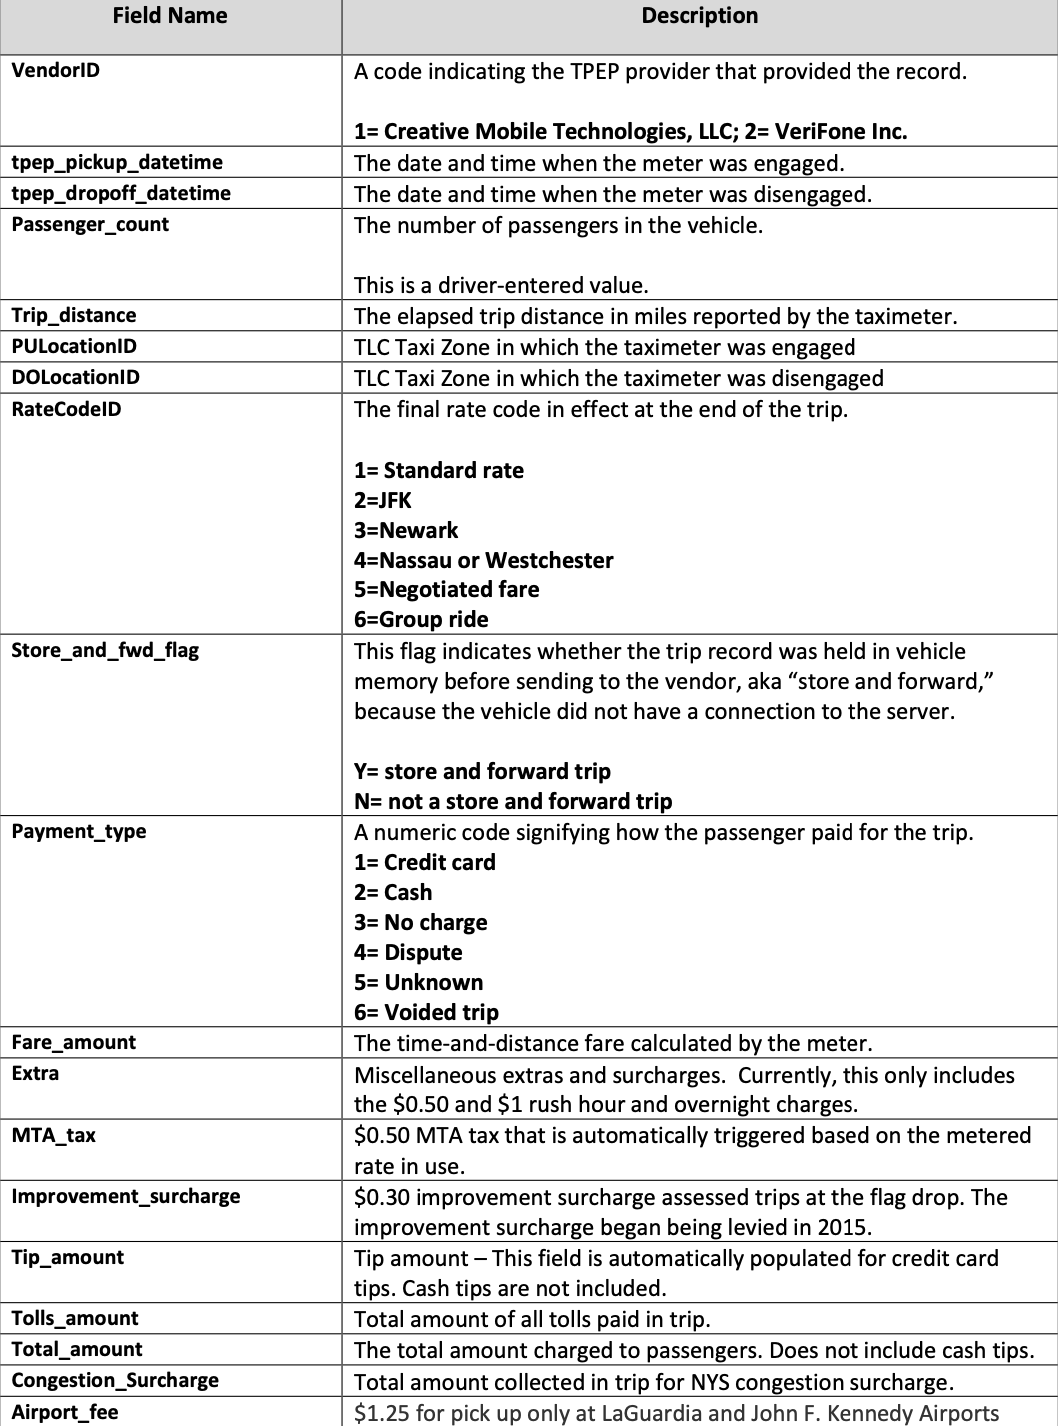

In [ ]:
# rows and columns of the dataset
taxi_data.shape

(1048575, 19)

In [ ]:
# converting pickup and dropoff to datetime
taxi_data['tpep_pickup_datetime'] = pd.to_datetime(taxi_data['tpep_pickup_datetime'], format='%d-%m-%Y %H:%M', errors='raise') # Specifying the correct format for day-month-year
taxi_data['tpep_dropoff_datetime'] = pd.to_datetime(taxi_data['tpep_dropoff_datetime'], format='%d-%m-%Y %H:%M', errors='raise') # Specifying the correct format for day-month-year

# subtracting the pickup time from dropoff time to get duration
taxi_data['duration'] = taxi_data['tpep_dropoff_datetime'] - taxi_data['tpep_pickup_datetime']

# converting into minutes
taxi_data['duration'] = taxi_data['duration'].dt.total_seconds()/60

In [ ]:
# datatypes of the data
taxi_data.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
duration                        float64
dtype: object

In [ ]:
taxi_data.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2024-08-01 00:21:00   2024-08-01 00:36:00                1   
1         2  2024-08-01 00:20:00   2024-08-01 00:41:00                1   
2         1  2024-08-01 00:17:00   2024-08-01 00:41:00                0   
3         1  2024-08-01 00:49:00   2024-08-01 00:55:00                0   
4         1  2024-08-01 00:38:00   2024-08-01 00:42:00                1   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           7.40           1                  N           138            80   
1           9.91           1                  N           138           239   
2          13.40           1                  N           138            88   
3           3.90           1                  N           209           137   
4           0.40           1                  N           148           144   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1         28.9   7.75      0.5        7.65          0.00   
1             1         40.8   6.00      0.5       11.55          6.94   
2             1         52.0  10.25      0.5       15.00          0.00   
3             3         17.0   3.50      0.5        0.00          0.00   
4             2          5.1   3.50      0.5        0.00          0.00   

   improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  \
0                    1.0         45.80                   0.0         1.75   
1                    1.0         71.04                   2.5         1.75   
2                    1.0         78.75                   2.5         1.75   
3                    1.0         22.00                   2.5         0.00   
4                    1.0         10.10                   2.5         0.00   

   duration  
0      15.0  
1      21.0  
2      24.0  
3       6.0  
4       4.0

In [ ]:
taxi_data.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
Airport_fee              0
duration                 0
dtype: int64

In [ ]:
taxi_data.nunique()

VendorID                     2
tpep_pickup_datetime     16901
tpep_dropoff_datetime    16999
passenger_count             10
trip_distance             4087
RatecodeID                   7
store_and_fwd_flag           2
PULocationID               253
DOLocationID               260
payment_type                 4
fare_amount               2402
extra                       54
mta_tax                      4
tip_amount                3697
tolls_amount               740
improvement_surcharge        4
total_amount             15539
congestion_surcharge         3
Airport_fee                  3
duration                   476
dtype: int64

In [ ]:
taxi_data.describe()

VendorID           tpep_pickup_datetime  \
count  1.048575e+06                        1048575   
mean   1.764314e+00  2024-08-06 16:29:01.696587520   
min    1.000000e+00            2009-01-01 00:02:00   
25%    2.000000e+00            2024-08-03 17:55:00   
50%    2.000000e+00            2024-08-06 17:45:00   
75%    2.000000e+00            2024-08-09 12:06:00   
max    2.000000e+00            2024-08-13 16:46:00   
std    4.244267e-01                            NaN   

               tpep_dropoff_datetime  passenger_count  trip_distance  \
count                        1048575     1.048575e+06   1.048575e+06   
mean   2024-08-06 16:46:30.771932928     1.359175e+00   3.968159e+00   
min              2009-01-01 20:28:00     0.000000e+00   0.000000e+00   
25%              2024-08-03 18:13:00     1.000000e+00   1.000000e+00   
50%              2024-08-06 18:03:00     1.000000e+00   1.710000e+00   
75%              2024-08-09 12:22:00     1.000000e+00   3.400000e+00   
max              2024-08-13 17:04:00     9.000000e+00   1.028428e+05   
std                              NaN     8.392191e-01   1.712931e+02   

         RatecodeID  PULocationID  DOLocationID  payment_type   fare_amount  \
count  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06   
mean   2.619059e+00  1.627995e+02  1.621202e+02  1.252665e+00  1.957616e+01   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00 -1.174100e+03   
25%    1.000000e+00  1.320000e+02  1.130000e+02  1.000000e+00  8.600000e+00   
50%    1.000000e+00  1.610000e+02  1.620000e+02  1.000000e+00  1.350000e+01   
75%    1.000000e+00  2.310000e+02  2.330000e+02  1.000000e+00  2.190000e+01   
max    9.900000e+01  2.650000e+02  2.650000e+02  4.000000e+00  1.386200e+03   
std    1.209061e+01  6.316020e+01  6.948528e+01  5.943795e-01  2.169831e+01   

              extra       mta_tax    tip_amount  tolls_amount  \
count  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06   
mean   1.468427e+00  4.745641e-01  3.491211e+00  6.275080e-01   
min   -7.500000e+00 -5.000000e-01 -9.000000e+01 -5.226000e+01   
25%    0.000000e+00  5.000000e-01  0.000000e+00  0.000000e+00   
50%    1.000000e+00  5.000000e-01  2.720000e+00  0.000000e+00   
75%    2.500000e+00  5.000000e-01  4.340000e+00  0.000000e+00   
max    1.425000e+01  3.000000e+00  3.333300e+02  9.770000e+01   
std    1.842071e+00  1.445011e-01  4.266801e+00  2.402456e+00   

       improvement_surcharge  total_amount  congestion_surcharge  \
count           1.048575e+06  1.048575e+06          1.048575e+06   
mean            9.491499e-01  2.840543e+01          2.189872e+00   
min            -1.000000e+00 -9.900000e+02         -2.500000e+00   
25%             1.000000e+00  1.548000e+01          2.500000e+00   
50%             1.000000e+00  2.064000e+01          2.500000e+00   
75%             1.000000e+00  3.072000e+01          2.500000e+00   
max             1.000000e+00  1.404830e+03          2.500000e+00   
std             2.915509e-01  2.655178e+01          9.286112e-01   

        Airport_fee      duration  
count  1.048575e+06  1.048575e+06  
mean   1.629979e-01  1.748459e+01  
min   -1.750000e+00 -2.200000e+01  
25%    0.000000e+00  7.000000e+00  
50%    0.000000e+00  1.300000e+01  
75%    0.000000e+00  2.100000e+01  
max    1.750000e+00  9.027000e+03  
std    5.293920e-01  3.903972e+01

In [ ]:
#EDA

In [ ]:
# 1. Check for missing values
missing_values = taxi_data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
Airport_fee              0
duration                 0
dtype: int64


In [ ]:
#2.Check for duplicate rows
duplicate_rows = taxi_data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")


Number of duplicate rows: 31


In [ ]:
#Drop duplicate rows
taxi_data = taxi_data.drop_duplicates()

In [ ]:
# rows and columns of the dataset
taxi_data.shape

(1048544, 20)

In [ ]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048544 entries, 0 to 1048574
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1048544 non-null  int64         
 1   tpep_pickup_datetime   1048544 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  1048544 non-null  datetime64[ns]
 3   passenger_count        1048544 non-null  int64         
 4   trip_distance          1048544 non-null  float64       
 5   RatecodeID             1048544 non-null  int64         
 6   store_and_fwd_flag     1048544 non-null  object        
 7   PULocationID           1048544 non-null  int64         
 8   DOLocationID           1048544 non-null  int64         
 9   payment_type           1048544 non-null  int64         
 10  fare_amount            1048544 non-null  float64       
 11  extra                  1048544 non-null  float64       
 12  mta_tax                1048544 no

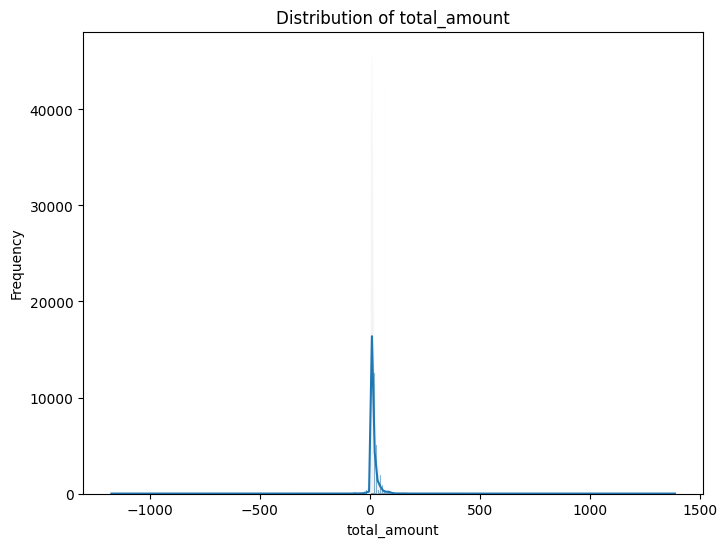

In [ ]:
# Explore the distribution of total_amount
plt.figure(figsize=(8, 6))
sns.histplot(taxi_data['fare_amount'], kde=True)
plt.title('Distribution of total_amount')
plt.xlabel('total_amount')
plt.ylabel('Frequency')
plt.show()



Payment Type Distribution:
 payment_type
1    844289
2    169166
4     25567
3      9522
Name: count, dtype: int64


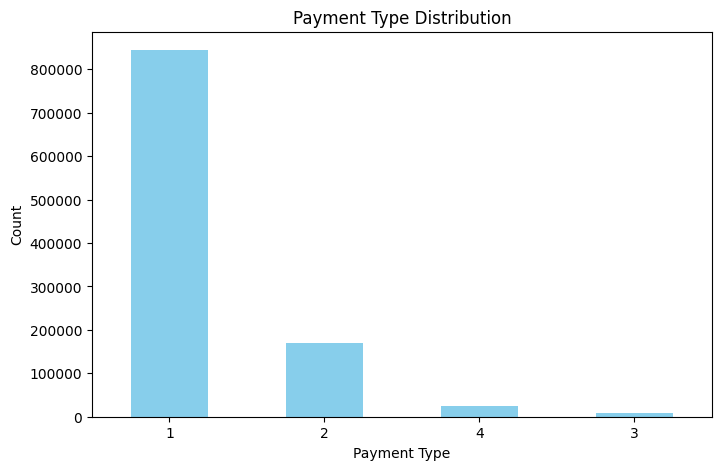

In [ ]:
# Check unique values and distribution of payment_type
payment_type_counts = taxi_data['payment_type'].value_counts()
print("Payment Type Distribution:\n", payment_type_counts)

# Visualize payment type distribution
plt.figure(figsize=(8, 5))
payment_type_counts.plot(kind='bar', color='skyblue')
plt.title('Payment Type Distribution')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Explore payment types
payment_type_counts = taxi_data['payment_type'].value_counts()
print(payment_type_counts)

payment_type
1    844289
2    169166
4     25567
3      9522
Name: count, dtype: int64


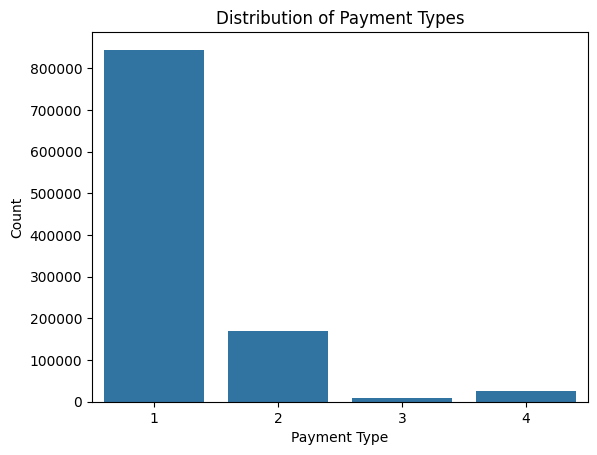

In [ ]:
# Visualize payment type distribution
sns.countplot(data=taxi_data, x='payment_type')
plt.title('Distribution of Payment Types')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.show()

In [ ]:
!pip install plotly
!pip install plotly.express -q
import plotly.express as px

In [ ]:
fig = px.scatter(taxi_data, x='trip_distance', y='total_amount', \
                   color='passenger_count', \
                   template='plotly_dark', \
                   labels={'total_amount':'Total Fare'})
fig.show()

In [ ]:
fig = px.scatter(taxi_data, x='trip_distance', y='fare_amount',
                 title='Fare Amount vs Trip Distance',
                 color='payment_type', labels={'trip_distance': 'Trip Distance', 'fare_amount': 'Fare Amount'})
fig.update_layout(template='plotly')
fig.show()


In [ ]:
import plotly.figure_factory as ff

# Create the distribution plot for `fare_amount`
fig = ff.create_distplot(
    [taxi_data['fare_amount']],  # Data as a list
    group_labels=['Fare Amount'],  # Legend label
    show_hist=True,  # Show histogram
    show_rug=False  # Hide rug plot for simplicity
)

# Update layout for better styling
fig.update_layout(
    title='Distribution of Fare Amount',
    xaxis_title='Fare Amount',
    yaxis_title='Frequency',
    template='plotly_dark',
    width=800,
    height=600
)

fig.show()


In [ ]:
fig = px.pie(taxi_data, names='payment_type', title='Payment Type Distribution')
fig.update_traces(textinfo='percent+label')
fig.show()


In [ ]:
taxi_data['pickup_hour'] = pd.to_datetime(taxi_data['tpep_pickup_datetime']).dt.hour

fig = px.histogram(taxi_data, x='pickup_hour', nbins=24, title='Trips by Hour of Day')
fig.update_layout(xaxis_title='Hour of Day', yaxis_title='Number of Trips', template='plotly_dark')
fig.show()


In [ ]:
fig = px.box(taxi_data, x='payment_type', y='fare_amount',
             title='Fare Amount by Payment Type',
             labels={'payment_type': 'Payment Type', 'fare_amount': 'Fare Amount'})
fig.update_layout(template='plotly')
fig.show()


Applying Stratified Sampling

In [ ]:
# Define features (X) and target (y)
X = taxi_data.drop(columns=['fare_amount'])
y = taxi_data['fare_amount']
y = y.astype(float)


In [ ]:
# Set desired sample size
desired_sample_size = 600000

# Combine features and target for easier manipulation
data = pd.concat([X, y], axis=1)

# Separate important data (fare_amount > 150)
important_data = data[data['fare_amount'] > 150]

# Calculate the remaining sample size
remaining_sample_size = desired_sample_size - len(important_data)
remaining_sample_size = max(remaining_sample_size, 0)

# Handle remaining data (fare_amount <= 150)
remaining_data = data[data['fare_amount'] <= 150]
frac = remaining_sample_size / len(remaining_data)
sampled_remaining_data = remaining_data.groupby('fare_amount', group_keys=False).apply(
    lambda x: x.sample(frac=frac, random_state=42)
)

In [ ]:

# Combine important data and stratified sampled remaining data
sampled_data = pd.concat([important_data, sampled_remaining_data])

# Ensure the final dataset size matches the desired size
sampled_data = sampled_data.sample(n=desired_sample_size, random_state=42) if len(sampled_data) > desired_sample_size else sampled_data



In [ ]:
# Check the shape of the sampled data
sampled_data.shape


(600000, 21)

In [ ]:
new_df= sampled_data.copy()
new_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
895634          2  2024-08-10 17:33:00   2024-08-10 17:34:00                1   
749535          2  2024-08-08 21:15:00   2024-08-08 21:21:00                3   
305370          2  2024-08-04 04:41:00   2024-08-04 04:50:00                1   
69703           1  2024-08-01 18:47:00   2024-08-01 18:54:00                1   
1024786         2  2024-08-12 12:33:00   2024-08-12 12:45:00                1   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
895634            0.36           1                  N           229   
749535            0.73           1                  N           142   
305370            2.69           1                  N           114   
69703             1.10           1                  N           237   
1024786           1.47           1                  N           186   

         DOLocationID  payment_type  ...  mta_tax  tip_amount  tolls_amount  \
895634            141             1  ...      0.5        1.00           0.0   
749535            143             1  ...      0.5        2.20           0.0   
305370             66             1  ...      0.5        3.70           0.0   
69703             236             1  ...      0.5        3.95           0.0   
1024786           161             1  ...      0.5        3.36           0.0   

         improvement_surcharge  total_amount  congestion_surcharge  \
895634                     1.0          8.70                   2.5   
749535                     1.0         14.40                   2.5   
305370                     1.0         22.20                   2.5   
69703                      1.0         19.75                   2.5   
1024786                    1.0         20.16                   2.5   

         Airport_fee  duration  pickup_hour  fare_amount  
895634           0.0       1.0           17          3.7  
749535           0.0       6.0           21          7.2  
305370           0.0       9.0            4         13.5  
69703            0.0       7.0           18          9.3  
1024786          0.0      12.0           12         12.8  

[5 rows x 21 columns]

In [ ]:
new_df.tail()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
443045         2  2024-08-05 19:39:00   2024-08-05 19:55:00                1   
84235          2  2024-08-01 20:20:00   2024-08-01 20:23:00                1   
828792         1  2024-08-09 20:03:00   2024-08-09 20:19:00                1   
875607         2  2024-08-10 13:53:00   2024-08-10 14:38:00                2   
261692         2  2024-08-03 17:46:00   2024-08-03 17:53:00                1   

        trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
443045           2.58           1                  N           107   
84235            0.40           1                  N           230   
828792           2.20           1                  N           163   
875607          19.66           3                  N           164   
261692           0.74           1                  N           233   

        DOLocationID  payment_type  ...  mta_tax  tip_amount  tolls_amount  \
443045           231             1  ...      0.5        0.00          0.00   
84235            100             1  ...      0.5        2.52          0.00   
828792            68             1  ...      0.5        4.00          0.00   
875607             1             2  ...      0.0        0.00         20.98   
261692           229             1  ...      0.5        2.24          0.00   

        improvement_surcharge  total_amount  congestion_surcharge  \
443045                    1.0         22.80                   2.5   
84235                     1.0         12.62                   2.5   
828792                    1.0         23.90                   2.5   
875607                    1.0        121.28                   0.0   
261692                    1.0         13.44                   2.5   

        Airport_fee  duration  pickup_hour  fare_amount  
443045          0.0      16.0           19         16.3  
84235           0.0       3.0           20          5.1  
828792          0.0      16.0           20         14.9  
875607          0.0      45.0           13         99.3  
261692          0.0       7.0           17          7.2  

[5 rows x 21 columns]

In [ ]:
#DroppingMissingValues
sampled_data.dropna(inplace=True)

In [ ]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600000 entries, 895634 to 261692
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               600000 non-null  int64         
 1   tpep_pickup_datetime   600000 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  600000 non-null  datetime64[ns]
 3   passenger_count        600000 non-null  int64         
 4   trip_distance          600000 non-null  float64       
 5   RatecodeID             600000 non-null  int64         
 6   store_and_fwd_flag     600000 non-null  object        
 7   PULocationID           600000 non-null  int64         
 8   DOLocationID           600000 non-null  int64         
 9   payment_type           600000 non-null  int64         
 10  extra                  600000 non-null  float64       
 11  mta_tax                600000 non-null  float64       
 12  tip_amount             600000 non-null  floa

In [ ]:
sampled_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'Airport_fee', 'duration', 'pickup_hour',
       'fare_amount'],
      dtype='object')

In [ ]:
# Convert 'pickup_datetime' to a proper datetime object
sampled_data['pickup_datetime'] = pd.to_datetime(sampled_data['tpep_pickup_datetime'])


In [ ]:
# Extract datetime features
sampled_data['year'] = sampled_data['pickup_datetime'].dt.year
sampled_data['month'] = sampled_data['pickup_datetime'].dt.month
sampled_data['day'] = sampled_data['pickup_datetime'].dt.day
sampled_data['hour'] = sampled_data['pickup_datetime'].dt.hour
sampled_data['minute'] = sampled_data['pickup_datetime'].dt.minute
sampled_data['day_of_week'] = sampled_data['pickup_datetime'].dt.dayofweek  # Monday=0, Sunday=6

In [ ]:
def is_rush_hour(row):
    hour = row['hour']
    day_of_week = row['day_of_week']
    return 1 if (7 <= hour <= 9 and 0 <= day_of_week <= 4) or (16 <= hour <= 18 and 0 <= day_of_week <= 4) else 0

sampled_data['rush_hour'] = sampled_data.apply(is_rush_hour, axis=1)

In [ ]:
#Dropping Columns that will not be used
sampled_data.drop(columns=['VendorID','tpep_pickup_datetime','tpep_dropoff_datetime','RatecodeID','store_and_fwd_flag','PULocationID','DOLocationID','extra','mta_tax',
       'tip_amount','tolls_amount','improvement_surcharge','total_amount','congestion_surcharge','Airport_fee','pickup_hour'], inplace=True)

In [ ]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600000 entries, 895634 to 261692
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   passenger_count  600000 non-null  int64         
 1   trip_distance    600000 non-null  float64       
 2   payment_type     600000 non-null  int64         
 3   duration         600000 non-null  float64       
 4   fare_amount      600000 non-null  float64       
 5   pickup_datetime  600000 non-null  datetime64[ns]
 6   year             600000 non-null  int32         
 7   month            600000 non-null  int32         
 8   day              600000 non-null  int32         
 9   hour             600000 non-null  int32         
 10  minute           600000 non-null  int32         
 11  day_of_week      600000 non-null  int32         
 12  rush_hour        600000 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int32(6), int64(3)
memory usage: 50.4 MB

In [ ]:
sampled_data.dtypes

passenger_count             int64
trip_distance             float64
payment_type                int64
duration                  float64
fare_amount               float64
pickup_datetime    datetime64[ns]
year                        int32
month                       int32
day                         int32
hour                        int32
minute                      int32
day_of_week                 int32
rush_hour                   int64
dtype: object

In [ ]:
sampled_data.shape

(600000, 13)

Dropping rows that won't be used

In [ ]:
sampled_data.describe()

passenger_count  trip_distance   payment_type       duration  \
count    600000.000000  600000.000000  600000.000000  600000.000000   
mean          1.359113       4.176832       1.252823      17.506062   
min           0.000000       0.000000       1.000000       0.000000   
25%           1.000000       1.000000       1.000000       7.000000   
50%           1.000000       1.710000       1.000000      13.000000   
75%           1.000000       3.420000       1.000000      21.000000   
max           9.000000  102842.800000       4.000000    9027.000000   
std           0.839440     204.074351       0.595291      38.727886   

         fare_amount                pickup_datetime           year  \
count  600000.000000                         600000  600000.000000   
mean       19.817677  2024-08-06 15:59:32.636100352    2023.999975   
min     -1174.100000            2009-01-01 00:05:00    2009.000000   
25%         8.600000            2024-08-03 17:33:00    2024.000000   
50%        13.500000            2024-08-06 17:21:00    2024.000000   
75%        22.500000            2024-08-09 11:44:00    2024.000000   
max      1386.200000            2024-08-13 16:46:00    2024.000000   
std        23.405573                            NaN       0.019365   

               month            day           hour         minute  \
count  600000.000000  600000.000000  600000.000000  600000.000000   
mean        7.999973       6.069730      14.064782      29.573835   
min         1.000000       1.000000       0.000000       0.000000   
25%         8.000000       3.000000      10.000000      14.000000   
50%         8.000000       6.000000      15.000000      30.000000   
75%         8.000000       9.000000      18.000000      45.000000   
max         8.000000      31.000000      23.000000      59.000000   
std         0.009832       3.315851       5.730034      17.337725   

         day_of_week      rush_hour  
count  600000.000000  600000.000000  
mean        3.259927       0.226278  
min         0.000000       0.000000  
25%         2.000000       0.000000  
50%         3.000000       0.000000  
75%         5.000000       0.000000  
max         6.000000       1.000000  
std         1.921275       0.418422

In [ ]:
#NOTE : fare_amount has the min value as -1174 which is not possible. So, we're going to handle all the negative values for fare_amount.

In [ ]:
negative_fares = sampled_data[sampled_data['fare_amount'] <= 0]
num_negative_fares = negative_fares.shape[0]

print(f'The number of fare_amount values less than or equal to 0: {num_negative_fares}')

The number of fare_amount values less than or equal to 0: 11282


In [ ]:
sampled_data = sampled_data[sampled_data['fare_amount'] > 0]

sampled_data.head()

passenger_count  trip_distance  payment_type  duration  fare_amount  \
895634                 1           0.36             1       1.0          3.7   
749535                 3           0.73             1       6.0          7.2   
305370                 1           2.69             1       9.0         13.5   
69703                  1           1.10             1       7.0          9.3   
1024786                1           1.47             1      12.0         12.8   

            pickup_datetime  year  month  day  hour  minute  day_of_week  \
895634  2024-08-10 17:33:00  2024      8   10    17      33            5   
749535  2024-08-08 21:15:00  2024      8    8    21      15            3   
305370  2024-08-04 04:41:00  2024      8    4     4      41            6   
69703   2024-08-01 18:47:00  2024      8    1    18      47            3   
1024786 2024-08-12 12:33:00  2024      8   12    12      33            0   

         rush_hour  
895634           0  
749535           0  
305370           0  
69703            1  
1024786          0

In [ ]:
#Also max value of passenger_count is 9 which isn't practical for 1 taxi ride. So we're setting the threshold to 6.

In [ ]:
max_passenger = sampled_data[sampled_data['passenger_count'] > 6]
max_passenger_count = max_passenger.shape[0]

print(f'The number of passenger_count values more than 6: {max_passenger_count}')

The number of passenger_count values more than 6: 6


In [ ]:
#Dropping those rows where passenger_count value is more than 6
sampled_data = sampled_data[sampled_data['passenger_count'] <= 6]

sampled_data.head()

passenger_count  trip_distance  payment_type  duration  fare_amount  \
895634                 1           0.36             1       1.0          3.7   
749535                 3           0.73             1       6.0          7.2   
305370                 1           2.69             1       9.0         13.5   
69703                  1           1.10             1       7.0          9.3   
1024786                1           1.47             1      12.0         12.8   

            pickup_datetime  year  month  day  hour  minute  day_of_week  \
895634  2024-08-10 17:33:00  2024      8   10    17      33            5   
749535  2024-08-08 21:15:00  2024      8    8    21      15            3   
305370  2024-08-04 04:41:00  2024      8    4     4      41            6   
69703   2024-08-01 18:47:00  2024      8    1    18      47            3   
1024786 2024-08-12 12:33:00  2024      8   12    12      33            0   

         rush_hour  
895634           0  
749535           0  
305370           0  
69703            1  
1024786          0

In [ ]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588669 entries, 895634 to 261692
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   passenger_count      588669 non-null  int64         
 1   trip_distance        588669 non-null  float64       
 2   payment_type         588669 non-null  int64         
 3   fare_amount          588669 non-null  float64       
 4   pickup_datetime      588669 non-null  datetime64[ns]
 5   year                 588669 non-null  int32         
 6   month                588669 non-null  int32         
 7   day                  588669 non-null  int32         
 8   hour                 588669 non-null  int32         
 9   minute               588669 non-null  int32         
 10  day_of_week          588669 non-null  int32         
 11  rush_hour            588669 non-null  int64         
 12  distance_per_minute  584584 non-null  float64       
dtypes: datetime64[

In [ ]:
# Ensure 'duration' has no zeros or missing values to avoid division by zero
sampled_data['duration'] = sampled_data['duration'].replace(0, np.nan)  # Replace 0 with NaN
sampled_data = sampled_data.dropna(subset=['duration'])  # Drop rows with NaN in 'duration'

# Create a new feature for distance per minute, ensuring no division by zero
sampled_data['distance_per_minute'] = sampled_data['trip_distance'] / sampled_data['duration']
sampled_data['distance_per_minute'].replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN

In [ ]:
# Verify the new feature
print(sampled_data['distance_per_minute'].describe())


count    583336.000000
mean          0.205407
std           8.433899
min           0.000000
25%           0.114286
50%           0.156667
75%           0.222000
max        6049.576471
Name: distance_per_minute, dtype: float64


In [ ]:
sampled_data.describe()

passenger_count  trip_distance   payment_type       duration  \
count    583336.000000  583336.000000  583336.000000  583336.000000   
mean          1.355264       4.209718       1.207049      17.713443   
min           0.000000       0.000000       1.000000       1.000000   
25%           1.000000       1.000000       1.000000       8.000000   
50%           1.000000       1.730000       1.000000      13.000000   
75%           1.000000       3.450000       1.000000      21.000000   
max           6.000000  102842.800000       4.000000    9027.000000   
std           0.836323     206.856260       0.499952      39.169639   

         fare_amount                pickup_datetime           year  \
count  583336.000000                         583336  583336.000000   
mean       20.449117  2024-08-06 15:58:23.281401600    2023.999974   
min         0.010000            2009-01-01 00:05:00    2009.000000   
25%         9.300000            2024-08-03 17:33:45    2024.000000   
50%        13.500000            2024-08-06 17:24:00    2024.000000   
75%        22.600000            2024-08-09 11:37:00    2024.000000   
max      1386.200000            2024-08-13 16:46:00    2024.000000   
std        21.530033                            NaN       0.019640   

               month            day           hour         minute  \
count  583336.000000  583336.000000  583336.000000  583336.000000   
mean        7.999973       6.068729      14.076361      29.574167   
min         1.000000       1.000000       0.000000       0.000000   
25%         8.000000       3.000000      11.000000      14.000000   
50%         8.000000       6.000000      15.000000      30.000000   
75%         8.000000       9.000000      18.000000      45.000000   
max         8.000000      31.000000      23.000000      59.000000   
std         0.009971       3.314429       5.712442      17.335695   

         day_of_week     rush_hour  distance_per_minute  
count  583336.000000  583336.00000        583336.000000  
mean        3.255781       0.22761             0.205407  
min         0.000000       0.00000             0.000000  
25%         2.000000       0.00000             0.114286  
50%         3.000000       0.00000             0.156667  
75%         5.000000       0.00000             0.222000  
max         6.000000       1.00000          6049.576471  
std         1.919615       0.41929             8.433899

In [ ]:
# Define a reasonable maximum distance threshold
max_distance_threshold = 100

# Remove rows with trip_distance greater than the threshold
sampled_data = sampled_data[sampled_data['trip_distance'] <= max_distance_threshold]

# Verify the maximum value after filtering
print(f"Max trip_distance after filtering: {sampled_data['trip_distance'].max()}")


Max trip_distance after filtering: 98.1


In [ ]:
sampled_data.shape

(583293, 14)

In [ ]:
sampled_data.describe()

passenger_count  trip_distance   payment_type       duration  \
count    583293.000000  583293.000000  583293.000000  583293.000000   
mean          1.355243       3.609626       1.207004      17.703207   
min           0.000000       0.000000       1.000000       1.000000   
25%           1.000000       1.000000       1.000000       8.000000   
50%           1.000000       1.730000       1.000000      13.000000   
75%           1.000000       3.450000       1.000000      21.000000   
max           6.000000      98.100000       4.000000    9027.000000   
std           0.836306       4.978746       0.499881      39.143578   

         fare_amount                pickup_datetime           year  \
count  583293.000000                         583293  583293.000000   
mean       20.411247  2024-08-06 15:58:23.957497088    2023.999974   
min         0.010000            2009-01-01 00:05:00    2009.000000   
25%         9.300000            2024-08-03 17:33:00    2024.000000   
50%        13.500000            2024-08-06 17:24:00    2024.000000   
75%        22.600000            2024-08-09 11:37:00    2024.000000   
max       989.000000            2024-08-13 16:46:00    2024.000000   
std        20.834307                            NaN       0.019640   

               month            day           hour         minute  \
count  583293.000000  583293.000000  583293.000000  583293.000000   
mean        7.999973       6.068741      14.076279      29.574259   
min         1.000000       1.000000       0.000000       0.000000   
25%         8.000000       3.000000      11.000000      14.000000   
50%         8.000000       6.000000      15.000000      30.000000   
75%         8.000000       9.000000      18.000000      45.000000   
max         8.000000      31.000000      23.000000      59.000000   
std         0.009972       3.314460       5.712382      17.335664   

         day_of_week      rush_hour  distance_per_minute  
count  583293.000000  583293.000000        583293.000000  
mean        3.255726       0.227620             0.186661  
min         0.000000       0.000000             0.000000  
25%         2.000000       0.000000             0.114286  
50%         3.000000       0.000000             0.156667  
75%         5.000000       0.000000             0.222000  
max         6.000000       1.000000            21.500000  
std         1.919607       0.419296             0.141097

In [ ]:
#Calculate the correlation matrix
correlation_matrix = sampled_data.corr()
print(correlation_matrix)

                     passenger_count  trip_distance  payment_type  duration  \
passenger_count             1.000000       0.067794      0.041081  0.036313   
trip_distance               0.067794       1.000000      0.003332  0.291180   
payment_type                0.041081       0.003332      1.000000 -0.001223   
duration                    0.036313       0.291180     -0.001223  1.000000   
fare_amount                 0.076112       0.915343      0.011776  0.289676   
pickup_datetime             0.002297       0.005665      0.003318 -0.036227   
year                       -0.001009       0.000292      0.000542 -0.040317   
month                      -0.000476      -0.001129      0.000795 -0.037245   
day                         0.005528       0.015504      0.008158  0.001213   
hour                        0.032825      -0.028589     -0.017144  0.003982   
minute                     -0.001021      -0.008994     -0.001645 -0.004153   
day_of_week                 0.059744       0.021824 

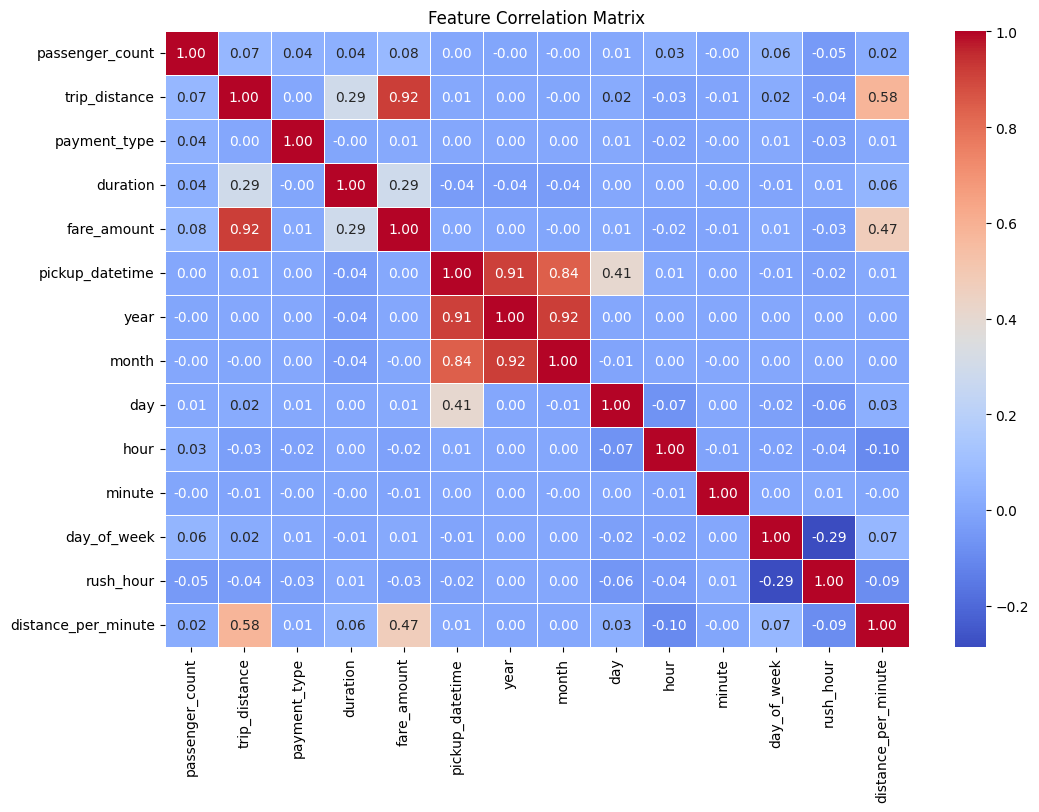

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
columns_to_drop = ['trip_distance', 'pickup_datetime','duration']  # Drop redundant features
sampled_data = sampled_data.drop(columns=columns_to_drop, errors='ignore')

In [ ]:
sampled_data.shape

(583293, 11)

In [ ]:
sampled_data = sampled_data[sampled_data['passenger_count'] > 0]

In [ ]:
sampled_data = sampled_data[sampled_data['distance_per_minute'] <= 5]

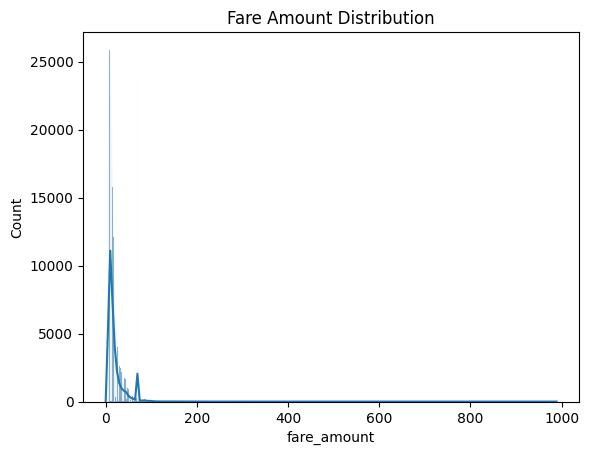

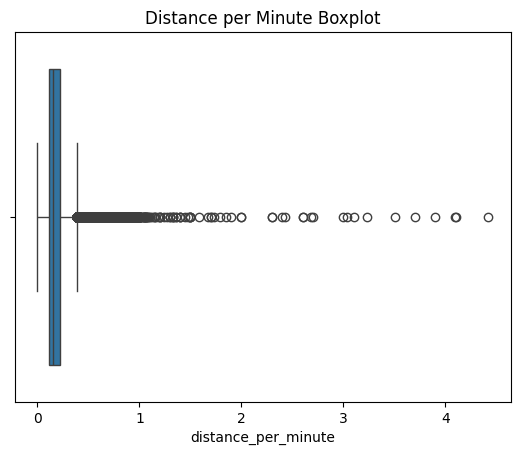

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize fare_amount
sns.histplot(sampled_data['fare_amount'], kde=True)
plt.title('Fare Amount Distribution')
plt.show()

# Boxplot for distance_per_minute
sns.boxplot(x=sampled_data['distance_per_minute'])
plt.title('Distance per Minute Boxplot')
plt.show()

In [ ]:
!pip install minepy -q

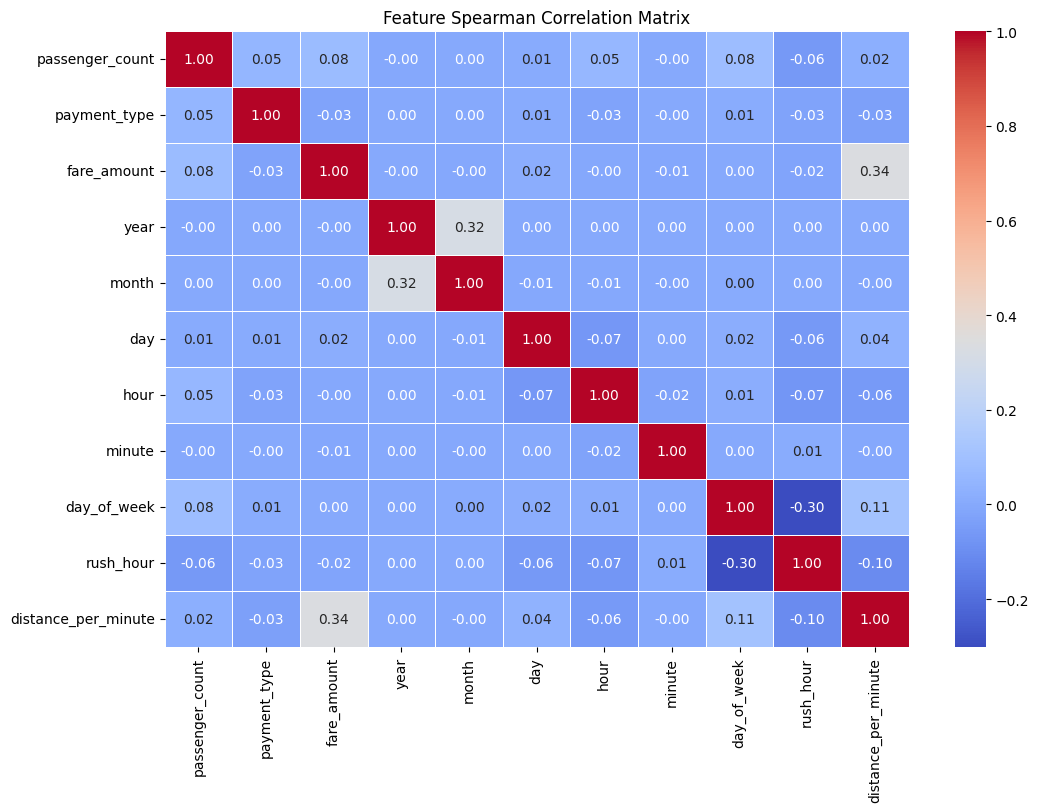

In [ ]:
spearman_corr_matrix = sampled_data.corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Spearman Correlation Matrix')
plt.show()

Define features and target variable

In [ ]:
X = sampled_data.drop(columns=['fare_amount'])
y = sampled_data['fare_amount']
y = y.astype(float)

if y.isnull().any():
    print("NaNs found in y_resampled and dropped.")
    X = X[~y.isnull()]
    y = y.dropna()

In [ ]:
X.describe()

passenger_count   payment_type           year          month  \
count    577495.000000  577495.000000  577495.000000  577495.000000   
mean          1.368814       1.206532    2023.999974       7.999972   
std           0.829373       0.499685       0.019739       0.010022   
min           1.000000       1.000000    2009.000000       1.000000   
25%           1.000000       1.000000    2024.000000       8.000000   
50%           1.000000       1.000000    2024.000000       8.000000   
75%           1.000000       1.000000    2024.000000       8.000000   
max           6.000000       4.000000    2024.000000       8.000000   

                 day           hour         minute    day_of_week  \
count  577495.000000  577495.000000  577495.000000  577495.000000   
mean        6.069571      14.082641      29.571740       3.255846   
std         3.314370       5.715912      17.336185       1.919495   
min         1.000000       0.000000       0.000000       0.000000   
25%         3.000000      11.000000      14.000000       2.000000   
50%         6.000000      15.000000      30.000000       3.000000   
75%         9.000000      18.000000      45.000000       5.000000   
max        31.000000      23.000000      59.000000       6.000000   

           rush_hour  distance_per_minute  
count  577495.000000        577495.000000  
mean        0.227424             0.186401  
std         0.419169             0.115620  
min         0.000000             0.000000  
25%         0.000000             0.114286  
50%         0.000000             0.156667  
75%         0.000000             0.222222  
max         1.000000             4.420000

In [ ]:
y.describe()

count    577495.000000
mean         20.443648
std          20.857144
min           0.010000
25%           9.300000
50%          13.500000
75%          22.600000
max         989.000000
Name: fare_amount, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_features = ['distance_per_minute', 'hour', 'minute', 'fare_amount']
sampled_data[numeric_features] = scaler.fit_transform(sampled_data[numeric_features])


In [ ]:
from sklearn.model_selection import train_test_split

X = sampled_data.drop(columns=['fare_amount'])  # Features
y = sampled_data['fare_amount']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (461996, 10), Test shape: (115499, 10)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Ensure 'X' is your features DataFrame or array

# Step 2: Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Optional: Check explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.19191969 0.13680248 0.1129494  0.10278817 0.10005137 0.09767683
 0.09539003 0.08574387 0.06860165]


Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import pandas as pd


In [ ]:
# Feature selection using SelectKBest with mutual_info_regression
fs = SelectKBest(score_func=mutual_info_regression, k=7)  # Select top 7 features
X_new = fs.fit_transform(X_train, y_train)  # Apply the transformation to select features

# Get selected feature names
selected_features_indices = fs.get_support(indices=True)  # Indices of selected features
selected_features = X_train.columns[selected_features_indices]  # Feature names

# Get mutual information scores
mutual_info_scores = fs.scores_  # Scores for all features
mutual_info_series = pd.Series(mutual_info_scores, index=X_train.columns, name='Mutual Information')
mutual_info_sorted = mutual_info_series[selected_features].sort_values(ascending=False)  # Sort selected features by score

print("Selected Features:\n", selected_features)
print("\nMutual Information Scores for Selected Features:\n", mutual_info_sorted)


Selected Features:
 Index(['passenger_count', 'payment_type', 'year', 'day', 'hour', 'day_of_week',
       'distance_per_minute'],
      dtype='object')

Mutual Information Scores for Selected Features:
 distance_per_minute    1.219547
hour                   0.013923
passenger_count        0.010639
payment_type           0.009927
day_of_week            0.003195
year                   0.002291
day                    0.002217
Name: Mutual Information, dtype: float64


In [ ]:
# Keep only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Verify the new shape
print(f"Shape of X_train after feature selection: {X_train_selected.shape}")


Shape of X_train after feature selection: (461996, 7)


In [ ]:
print("Columns in X_train:", X_train.columns)
print("Columns in X_test:", X_test.columns)


Columns in X_train: Index(['passenger_count', 'payment_type', 'year', 'month', 'day', 'hour',
       'minute', 'day_of_week', 'rush_hour', 'distance_per_minute'],
      dtype='object')
Columns in X_test: Index(['passenger_count', 'payment_type', 'year', 'month', 'day', 'hour',
       'minute', 'day_of_week', 'rush_hour', 'distance_per_minute'],
      dtype='object')


Data distribution of the training and testing data

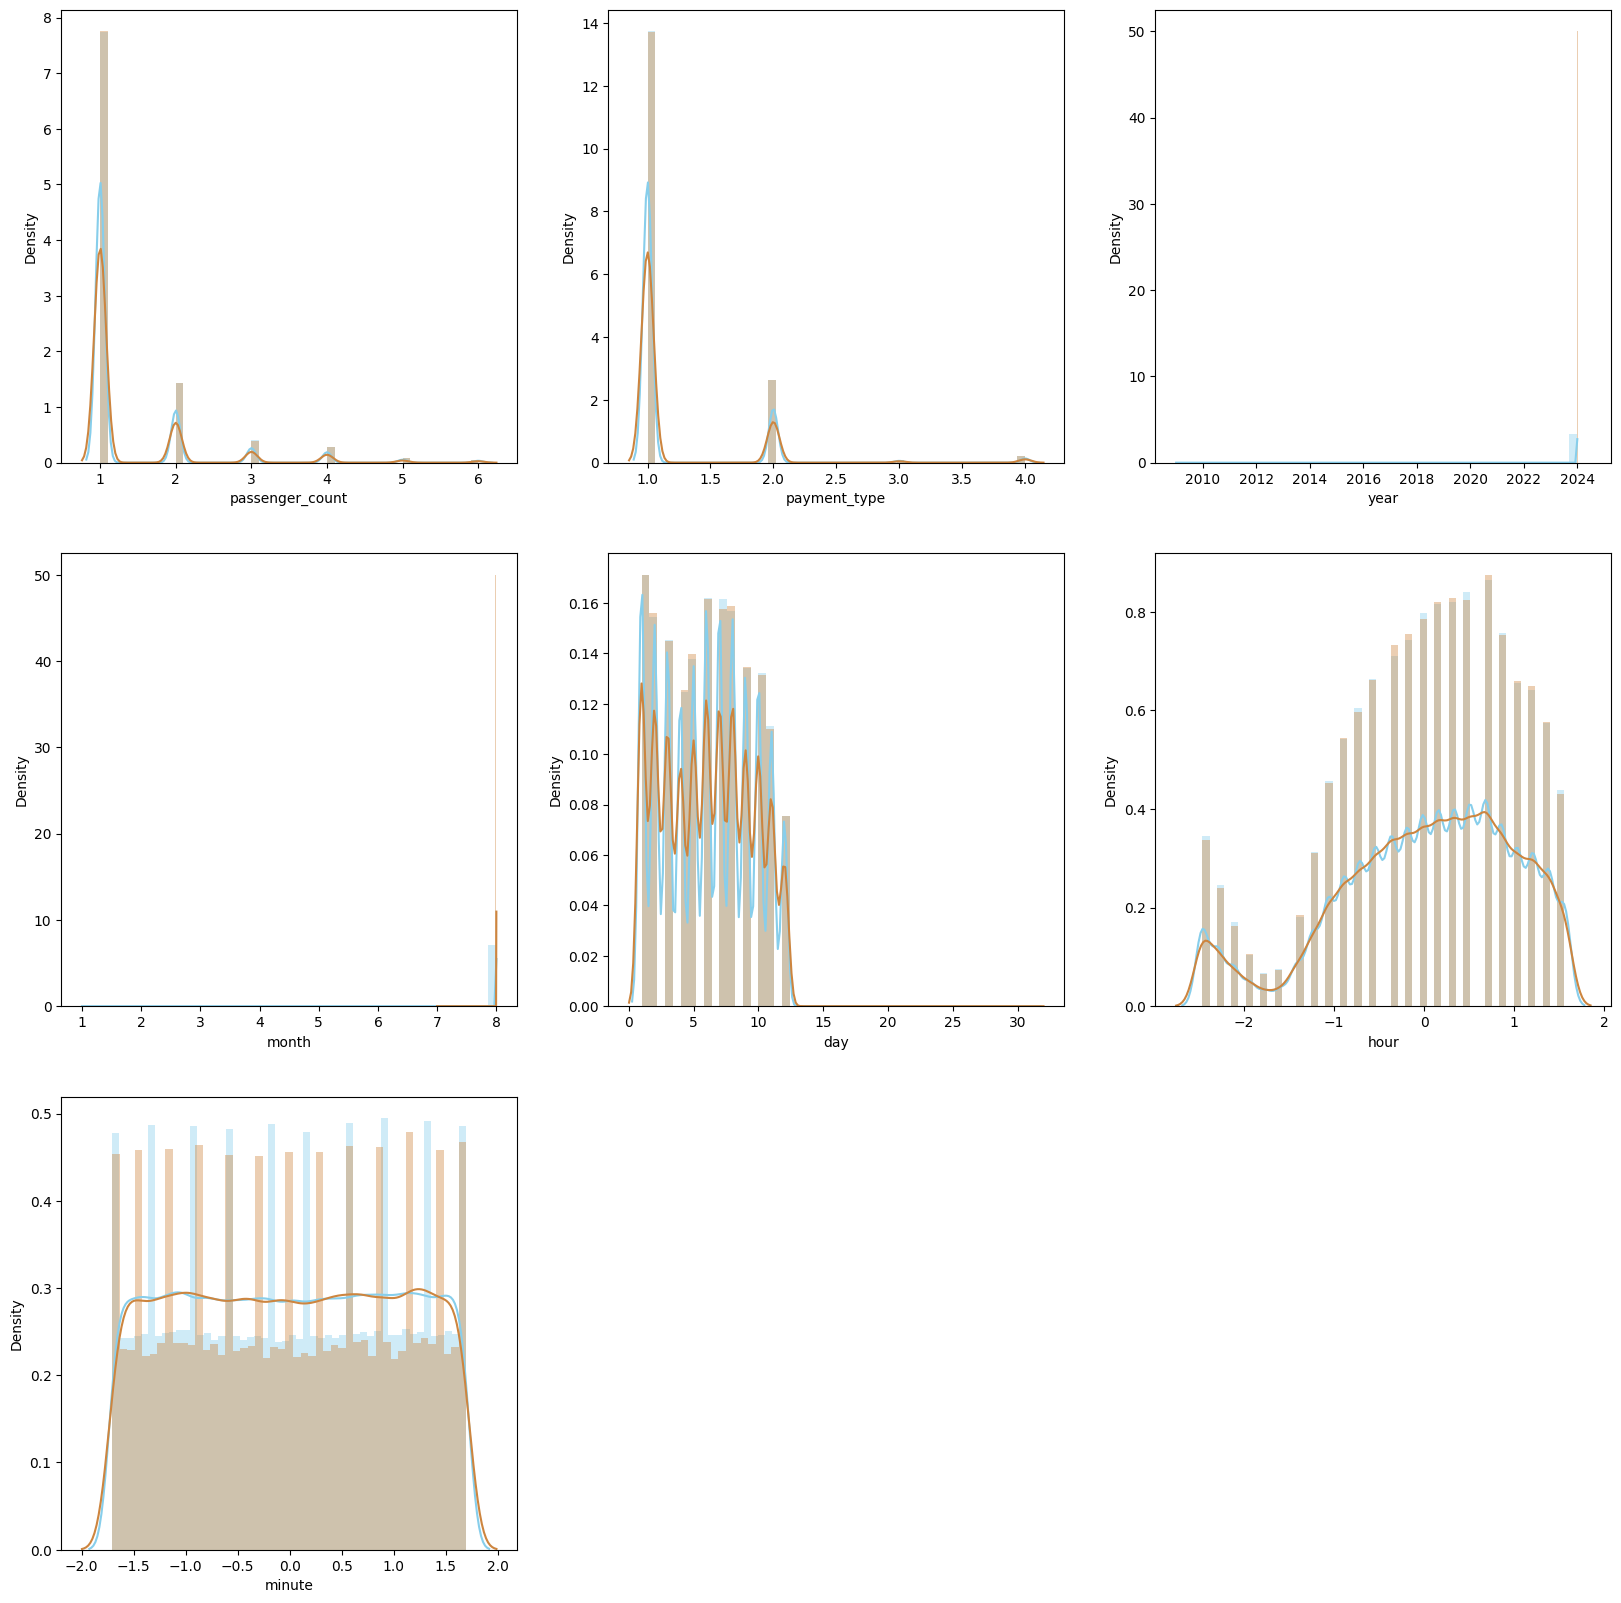

In [ ]:
plt.figure(figsize=(20,20))
for idx in range(7):
  plt.subplot(3,3,idx+1)
  sns.distplot(X_train.iloc[:,idx], color= 'skyblue')
  sns.distplot(X_test.iloc[:, idx], color= 'peru')

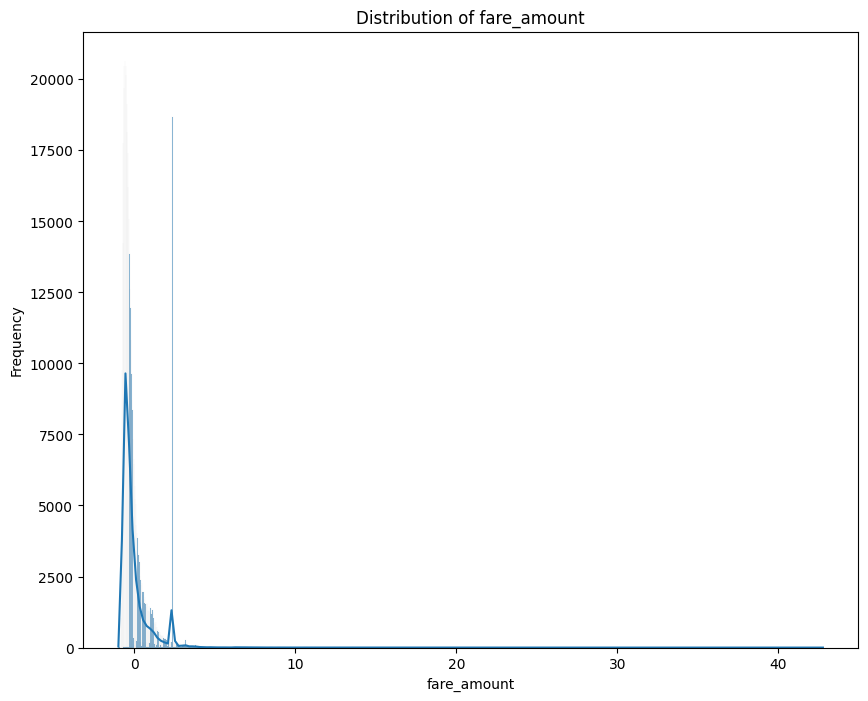

In [ ]:
plt.figure(figsize=(10, 8))
sns.histplot(y_train, kde=True)
plt.title('Distribution of fare_amount')
plt.xlabel('fare_amount')
plt.ylabel('Frequency')
plt.show()

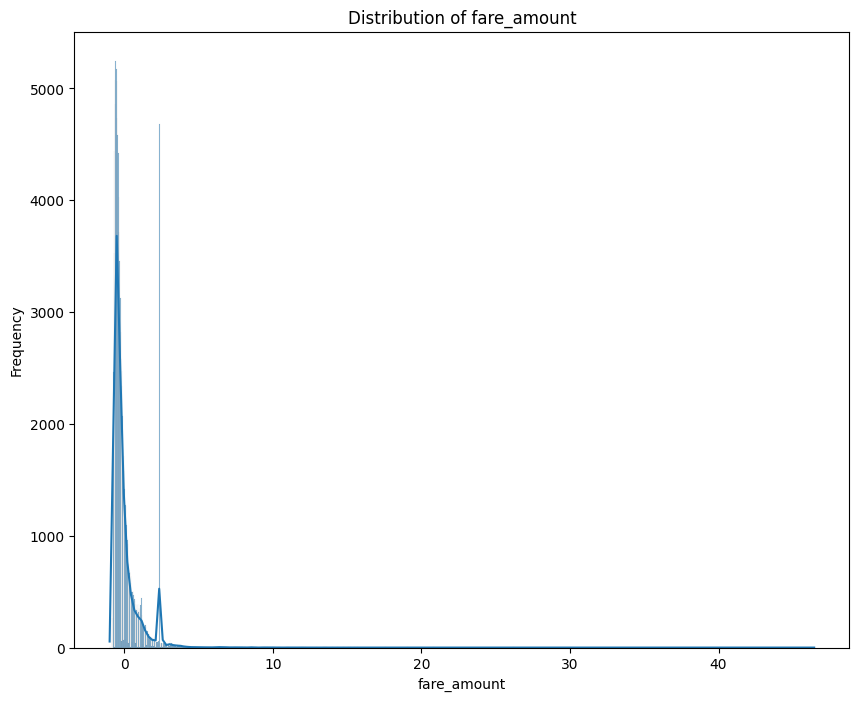

In [ ]:
plt.figure(figsize=(10, 8))
sns.histplot(y_test, kde=True)
plt.title('Distribution of fare_amount')
plt.xlabel('fare_amount')
plt.ylabel('Frequency')
plt.show()

Training the Model

In [ ]:
#LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
#makepredictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [ ]:
#modelevaluation
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

Train RMSE: 0.8162571989491187
Test RMSE: 0.8169096479501475
Train R2: 0.3345694555633416
Test R2: 0.32925049420091623


Ridge Regression Model

In [ ]:
from sklearn.linear_model import Ridge, Lasso

In [ ]:
def objective_ridge(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0.01, 10.0)
    }
    model = Ridge(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return score

study_ridge = optuna.create_study(direction='maximize')
study_ridge.optimize(objective_ridge, n_trials=30)

[I 2024-11-27 17:16:40,956] A new study created in memory with name: no-name-a0ba7dac-4755-4fb9-8348-982ca991e69f
[I 2024-11-27 17:16:41,698] Trial 0 finished with value: -0.8162669515137522 and parameters: {'alpha': 4.165548770435843}. Best is trial 0 with value: -0.8162669515137522.
[I 2024-11-27 17:16:42,508] Trial 1 finished with value: -0.8162669428920039 and parameters: {'alpha': 3.230978356856892}. Best is trial 1 with value: -0.8162669428920039.
[I 2024-11-27 17:16:43,356] Trial 2 finished with value: -0.8162669759586901 and parameters: {'alpha': 5.913623393797483}. Best is trial 1 with value: -0.8162669428920039.
[I 2024-11-27 17:16:43,970] Trial 3 finished with value: -0.8162669681443852 and parameters: {'alpha': 5.395016076938266}. Best is trial 1 with value: -0.8162669428920039.
[I 2024-11-27 17:16:45,000] Trial 4 finished with value: -0.8162670327873066 and parameters: {'alpha': 9.692489598099192}. Best is trial 1 with value: -0.8162669428920039.
[I 2024-11-27 17:16:46,198

In [ ]:
print("Best parameters for Ridge: ", study_ridge.best_params)

Best parameters for Ridge:  {'alpha': 2.628923829399794}


In [ ]:
ridge_model = Ridge(**study_ridge.best_params, random_state=42)
ridge_model.fit(X_train, y_train)

Ridge(alpha=2.628923829399794, random_state=42)

In [ ]:
#makepredictions
y_pred_train = ridge_model.predict(X_train)
y_pred_test = ridge_model.predict(X_test)

In [ ]:
#evaluatemodel
train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2_ridge = r2_score(y_train, y_pred_train)
test_r2_ridge = r2_score(y_test, y_pred_test)

print(f'Ridge Regression - Train RMSE: {train_rmse_ridge}')
print(f'Ridge Regression - Test RMSE: {test_rmse_ridge}')
print(f'Ridge Regression - Train R2: {train_r2_ridge}')
print(f'Ridge Regression - Test R2: {test_r2_ridge}')

Ridge Regression - Train RMSE: 0.8162571991476212
Ridge Regression - Test RMSE: 0.8169096406909664
Ridge Regression - Train R2: 0.3345694552396946
Ridge Regression - Test R2: 0.32925050612167683


Lasso Regression Model

In [ ]:
def objective_lasso(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0.01, 10.0)
    }
    model = Lasso(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return score

study_lasso = optuna.create_study(direction='maximize')
study_lasso.optimize(objective_lasso, n_trials=30)

[I 2024-11-27 17:19:46,203] A new study created in memory with name: no-name-ae40c32e-a77b-4884-b7df-b5c1e6f83ded
[I 2024-11-27 17:19:47,120] Trial 0 finished with value: -1.0005493651227901 and parameters: {'alpha': 8.446661305662849}. Best is trial 0 with value: -1.0005493651227901.
[I 2024-11-27 17:19:48,148] Trial 1 finished with value: -1.0005493651227901 and parameters: {'alpha': 3.447345876598904}. Best is trial 0 with value: -1.0005493651227901.
[I 2024-11-27 17:19:49,211] Trial 2 finished with value: -1.0005493651227901 and parameters: {'alpha': 0.8229928108104457}. Best is trial 0 with value: -1.0005493651227901.
[I 2024-11-27 17:19:50,580] Trial 3 finished with value: -1.0005493651227901 and parameters: {'alpha': 6.7681523775358885}. Best is trial 0 with value: -1.0005493651227901.
[I 2024-11-27 17:19:52,734] Trial 4 finished with value: -1.0005493651227901 and parameters: {'alpha': 8.652132478885903}. Best is trial 0 with value: -1.0005493651227901.
[I 2024-11-27 17:19:54,6

In [ ]:
print("Best parameters for Lasso: ", study_lasso.best_params)

Best parameters for Lasso:  {'alpha': 0.02085764370885987}


In [ ]:
lasso_model = Lasso(**study_lasso.best_params, random_state=42)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.02085764370885987, random_state=42)

In [ ]:
#modelevaluation
y_pred_train = lasso_model.predict(X_train)
y_pred_test = lasso_model.predict(X_test)

In [ ]:
train_rmse_Lasso = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse_Lasso = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2_Lasso = r2_score(y_train, y_pred_train)
test_r2_Lasso = r2_score(y_test, y_pred_test)

print(f'Lasso Regression - Train RMSE: {train_rmse_Lasso}')
print(f'Lasso Regression - Test RMSE: {test_rmse_Lasso}')
print(f'Lasso Regression - Train R2: {train_r2_Lasso}')
print(f'Lasso Regression - Test R2: {test_r2_Lasso}')

Lasso Regression - Train RMSE: 0.8181220853082534
Lasso Regression - Test RMSE: 0.818486153493268
Lasso Regression - Train R2: 0.3315253906870551
Lasso Regression - Test R2: 0.3266591166543106


Random Forest Regressor Model

In [ ]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, 50),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 6),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 3)
    }
    model = RandomForestRegressor(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
    return score

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)

[I 2024-11-27 17:21:58,564] A new study created in memory with name: no-name-8b4439ca-b71f-44f2-bd72-dac2b3feee49
[I 2024-11-27 17:46:58,536] Trial 0 finished with value: -0.7230689120378572 and parameters: {'n_estimators': 400, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: -0.7230689120378572.
[I 2024-11-27 17:52:51,839] Trial 1 finished with value: -0.7252516685224705 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: -0.7230689120378572.


In [ ]:
print(f'Best parameters for Random Forest: {study_rf.best_params}')

In [ ]:
rf_model = RandomForestRegressor(**study_rf.best_params, random_state=42)
rf_model.fit(X_train, y_train)

In [ ]:
#makepredictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

In [ ]:
#modelevaluation
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2_rf = r2_score(y_train, y_pred_train)
test_r2_rf = r2_score(y_test, y_pred_test)

print(f'Random Forest - Train RMSE: {train_rmse_rf}')
print(f'Random Forest - Test RMSE: {test_rmse_rf}')
print(f'Random Forest - Train R2: {train_r2_rf}')
print(f'Random Forest - Test R2: {test_r2_rf}')

In [ ]:
#Gradient Boosting Regressor Model

In [ ]:
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
    }
    model = GradientBoostingRegressor(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
    return score

study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=30)

In [ ]:
print(f'Best parameters for Gradient Boosting: {study_gb.best_params}')

In [ ]:
gb_model = GradientBoostingRegressor(**study_gb.best_params, random_state=42)
gb_model.fit(X_train, y_train)

In [ ]:
#makepredictions
y_pred_train_gb = gb_model.predict(X_train)
y_pred_test_gb = gb_model.predict(X_test)

In [ ]:
train_rmse_gb = np.sqrt(mean_squared_error(y_train, y_pred_train_gb))
test_rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_test_gb))
train_r2_gb = r2_score(y_train, y_pred_train_gb)
test_r2_gb = r2_score(y_test, y_pred_test_gb)

print(f'Gradient Boosting - Train RMSE: {train_rmse_gb}')
print(f'Gradient Boosting - Test RMSE: {test_rmse_gb}')
print(f'Gradient Boosting - Train R2: {train_r2_gb}')
print(f'Gradient Boosting - Test R2: {test_r2_gb}')

XgBoost Model

In [ ]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 20),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'max_leaves': trial.suggest_int('max_leaves', 2, 20)
    }
    model = XGBRegressor(**params, random_state=42, verbosity=0)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return score

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=50)

In [ ]:
print(f'Best parameters for XGBoost: {study_xgb.best_params}')

In [ ]:
xgb_model = XGBRegressor(**study_xgb.best_params, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)

In [ ]:
#makepredictions
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

In [ ]:
#modelevaluation
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
train_r2_xgb = r2_score(y_train, y_pred_train_xgb)
test_r2_xgb = r2_score(y_test, y_pred_test_xgb)

print(f'XGBoost - Train RMSE: {train_rmse_xgb}')
print(f'XGBoost - Test RMSE: {test_rmse_xgb}')
print(f'XGBoost - Train R2: {train_r2_xgb}')
print(f'XGBoost - Test R2: {test_r2_xgb}')

Pipeline


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Step 1: Define numerical and categorical features
numerical_features = ['passenger_count', 'year', 'day', 'hour', 'day_of_week', 'distance_per_minute']
categorical_features = ['payment_type']  # Example categorical feature (modify as per your dataset)

# Step 2: Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Standardize numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Encode categorical features
    ]
)

# Step 3: Create a pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # Replace with your best model if different
])

# Step 4: Fit the pipeline on training data
pipeline.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Step 6: Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Pipeline Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Step 7: Save the pipeline to a file
joblib.dump(pipeline, 'best_model_pipeline.pkl')
print("Pipeline saved as 'best_model_pipeline.pkl'")

# Step 8: Load the pipeline for future use
loaded_pipeline = joblib.load('best_model_pipeline.pkl')


Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for hyperparameter tuning
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

# Perform GridSearchCV with the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best RMSE: {-grid_search.best_score_}")

# Use the best model from GridSearchCV
best_pipeline = grid_search.best_estimator_

# Save the best pipeline
joblib.dump(best_pipeline, 'best_model_pipeline_tuned.pkl')
print("Tuned pipeline saved as 'best_model_pipeline_tuned.pkl'")
